# Modeling Tutorial: Quantum Types and Variables

This tutorial walks through Qmod quantum types and how to use variables of these types in code.

It assumes:

- You already have the Classiq SDK installed.
- You know how to run a synthesized model and inspect measurement results.


## Setup

Through this tutorial, you should import Classiq before using it:

In [1]:
from classiq import *



## 1. Concepts: quantum objects, types, and variables

Before anything, it is important to know there are three concepts we need to understand:

### **Quantum object**  
  The actual state stored on one or more qubits (e.g., a single qubit or an integer encoded in several qubits).

### **Quantum type**  
  The combination of the quantum object and classical metadata. Which allows the synthesis engine to know:
  - How a set of qubits are used.
  - How to interpret their state (e.g., a particular set of qubits represents the number 3,125. How does the quantum algorithm knows this? Answer: By defining the quantum type correctly).
  - Any extra attributes, such as signedness or fractional bits for numbers.

### **Quantum variable**  
  A named handle that refers to a quantum object of a given type.  
  Variables are introduced as:
  - Function parameters.
  - Local quantum variables inside a [Quantum Function](https://docs.classiq.io/latest/qmod-reference/language-reference/functions).

Once a variable is initialized, it is bound to a specific quantum object.

|                      | # of qubits | Interpretation                                               | Example Values                                                                     |
|----------------------|-------------|--------------------------------------------------------------|------------------------------------------------------------------------------------|
| `QBit`               | 1           | Single qubit                                                 | Any superposition between $\vert 0\rangle$ and $\vert 1\rangle$                    |
| `QNum[3, SIGNED, 1]` | 3           | Signed number with a fraction digit                          | States of 3 qubits that represent a signed number with a fraction digit            |
| `QArray[QBit, 4]`    | 4           | Set of 4 qubits                                              | Any superposition of 4 qubits                                                      |
| `QStruct`            |             | A quantum structure that may contain different quantum types | A single qubit in one field and a quantum number in another field of the `QStruct` |

## 2. `QBit`: the single-qubit type

### Declaring and allocating a single qubit

In [ ]:
@qfunc
def main(q: Output[QBit]):
    allocate(q)  # q refers to a fresh qubit in |0>
    H(q)  # put q in superposition

### Key points:

- `Output[QBit]` means `q` is uninitialized at the function entry.
- `allocate(q)` binds `q` to a fresh qubit in the $\vert 0 \rangle$ state.
- `H(q)` applies a Hadamard gate, creating a superposition of $\vert 0 \rangle$ and $\vert 1 \rangle$.

### Exercise 1: Prepare $\vert + \rangle$ and inspect results

**Goal**: Confirm that measuring $\vert + \rangle$ yields $\vert 0 \rangle$ and $\vert 1 \rangle$ with roughly equal probability.

In [6]:
@qfunc
def main(q: Output[QBit]):
    allocate(q)
    H(q)


qprog = synthesize(main)
show(qprog)

with ExecutionSession(qprog) as es:
    res = es.sample()

display(res.dataframe)

Quantum program link: https://platform.classiq.io/circuit/35eU2wkn0WFNnmJARQp0udsV7qC


,q,count,probability,bitstring
0,1,1056,0.515625,1
1,0,992,0.484375,0


What to inspect:

- **Circuit**: A single qubit with an H gate.
- **Measurement histogram**: Approximately 50% probability for `0` and 50% for `1`.


## 3. Quantum arrays of qubits

<center>

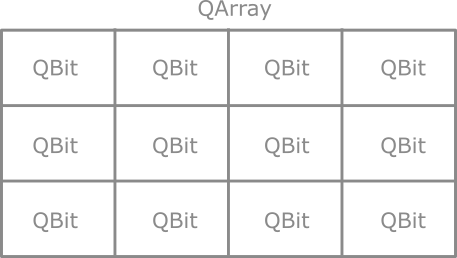

</center>

A quantum array is a fixed-size collection of elements of the same quantum type:

- `QArray[QBit]` → array of individual qubits.
- `QArray[QNum]` → array of quantum numbers.

### Declaring and allocating an array of qubits


In [ ]:
@qfunc
def main(arr: Output[QArray[QBit]]):
    allocate(5, arr)  # 5 qubits: arr[0] ... arr[4]
    hadamard_transform(arr)  # apply H to all five qubits

### Key points:

- `allocate(5, arr)` allocates 5 qubits to the quantum array `arr`.
- `hadamard_transform(arr)` is shorthand for applying H to each element of `arr`.

### Indexing, slicing, and using gates


In [ ]:
@qfunc
def array_indexing_demo(arr: Output[QArray[QBit]]):
    allocate(5, arr)

    hadamard_transform(arr[0:3])  # act on arr[0], arr[1], arr[2]
    CX(arr[2], arr[3])  # control = arr[2], target = arr[3]

### Notes:

- `arr[i]` behaves like a `QBit`.
- `arr[start:stop]` behaves like a quantum array.

### Exercise 2: Bell state in a `QArray[QBit]`

**Goal**: Prepare the Bell state  
$$
\vert \Phi^+\rangle = \frac{\vert 00\rangle + \vert 11\rangle}{\sqrt{2}}
$$  
using a 2-qubit array.

1. Define a `@qfunc` with an `Output[QArray[QBit]]` parameter.
2. Allocate an array of length 2.
3. Apply H to the first qubit.
4. Apply CX with the first qubit as control and the second as target.

**Reference solution:**

In [2]:
@qfunc
def main(arr: Output[QArray[QBit]]):
    allocate(2, arr)
    H(arr[0])
    CX(arr[0], arr[1])


qprog = synthesize(main)
show(qprog)

Quantum program link: https://platform.classiq.io/circuit/363yVO5Ks97VOujSORqXFIZSmPT


Expected behavior:

- Only `00` and `11` appear in measurement results.
- Probabilities are close to $50\%$-$50\%$.

#### Visualization in the Classiq Platform:

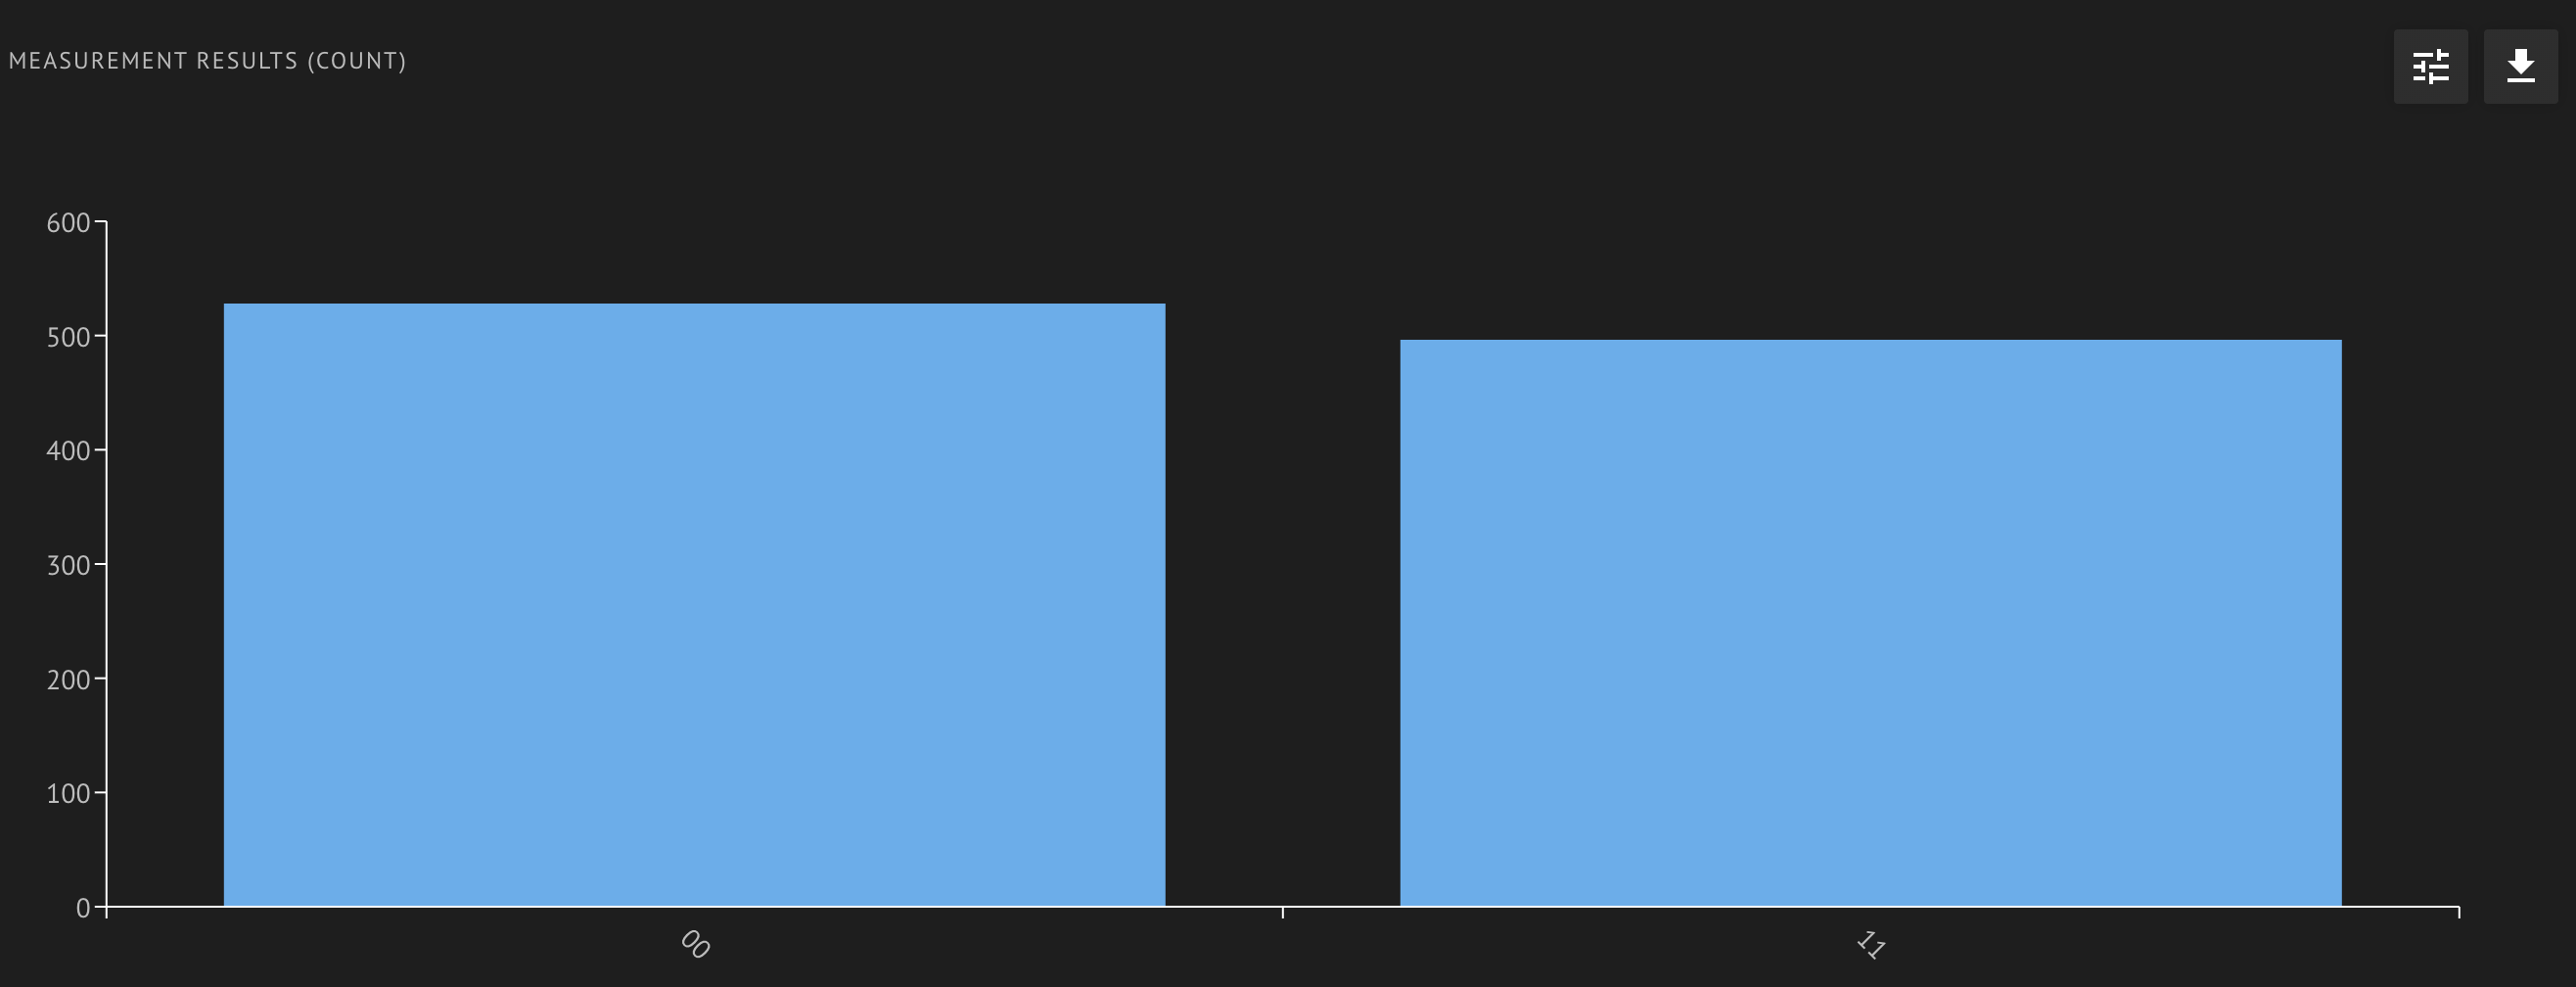

## 4. `QNum`: quantum numbers

`QNum` represents numbers encoded in multiple qubits, with configurable attributes.

A general form is:

```text
QNum[qbits, signed, fraction_bits]
```

- `qbits`: total number of qubits.
- `signed`: signedness (`SIGNED` / `UNSIGNED`).
- `fraction_bits`: number of qbits used for the binary fractional part.

### Examples:

- `QNum[3, False, 0]`  
  3-bit unsigned integer (values 0–7).
- `QNum[4, True, 0]`  
  4-bit signed integer (two’s complement).
- `QNum[5, True, 2]`  
  5-bit signed fixed-point with 2 fractional bits.

When some attributes are omitted (for example `QNum` or `QNum[qbits]`), Qmod may infer them from context in simple expressions.

<center>

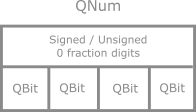

</center>

### Numeric superposition and a function $y(x)$

Example: create a uniform superposition over 3-bit integers and compute a function of `x`.

In [ ]:
@qfunc
def qnum_parabola(x: Output[QNum], y: Output[QNum]):
    allocate(3, x)  # 3 qubits → x ∈ {0, …, 7}
    hadamard_transform(x)  # uniform superposition over all x

    y |= x**2 + 1  # numeric assignment: y = x^2 + 1

Notes:

- `allocate(3, x)` fixes `x` to 3 bits where inference is not enough.
- `y |= expression` is a **numeric assignment**:
  - `y` is allocated and computed from `expression`.
  - Classiq compile it to a sequence of reversible quantum operations.

Table of 3-bit unsigned values:

| qubits | Value |
|--------|-------|
| 000    | 0     |
| 001    | 1     |
| 010    | 2     |
| 011    | 3     |
| 100    | 4     |
| 101    | 5     |
| 110    | 6     |
| 111    | 7     |

### Exercise 3: GHZ state encoded as a signed `QNum`

**Goal**: Create a 3-qubit `QNum` encoding $0$ and $−1$ with equal probability.

Steps:

1. Define a `qfunc` `number_superposition` that manipulates a `QArray`.
2. Inside this function:
   - `000` represent 0.
   - `111` represent −1 as a signed 3-qbit integer.
3. Prepare a GHZ-like state $\left(\vert 000\rangle + \vert 111\rangle\right)/\sqrt{2}$.
4. Use the type `QNum[3, SIGNED, 0]` (3-bit signed integer) in the `main` function calling .
5. Measure and interpret results as a signed integer.

Skeleton:

In [ ]:
from classiq import *


@qfunc
def number_superposition(x: QArray):
    # Your code here (remove pass)
    pass


@qfunc
def main(x: Output[QNum[3, True, 0]]):
    allocate(x)
    number_superposition(x)

### Questions:

1. Consider `a = QNum[3, SIGNED, 0]`. Which number does `111` represent? 
    <details markdown>
    <summary markdown> Answer </summary>
    -1
    </details>
2. What number does `a`represents if it is `UNSIGNED`?
    <details markdown>
    <summary markdown> Answer </summary>
    7
    </details>
3. Does your measurement output show probabilities close to 50% for 0 and 50% for −1?

Table of 3-bit signed values:

| Bits | Signed value |
|------|--------------|
| 000  | 0            |
| 001  | 1            |
| 010  | 2            |
| 011  | 3            |
| 100  | −4           |
| 101  | −3           |
| 110  | −2           |
| 111  | −1           |


## 5. Quantum arrays of numbers

Quantum arrays can store numeric elements:


In [ ]:
@qfunc
def main(
    bits: Output[QArray[QBit, 3]],
    nums: Output[QArray[QNum[2, False, 0], 4]],
):
    allocate(bits)  # 3 qubits total
    allocate(nums)  # 4 numeric elements, each with 2 qubits

### Notes:

- `bits` has 3 elements of type `QBit` → total 3 qubits.
- `nums` has 4 elements of type `QNum[2, False, 0]` → total 4 × 2 = 8 qubits.
- The array length refers to number of elements, not number of qubits.

You can act on individual elements or subarrays:

In [ ]:
@qfunc
def main(nums: Output[QArray[QNum[4, SIGNED, 0], 2]], x: Output[QBit]):
    allocate(nums)  # 2 numeric elements
    allocate(x)
    number_superposition(nums[0])  # superpose the first numeric element
    hadamard_transform(nums[1])
    x ^= (
        nums[0] + nums[1] == 3
    )  # Checks whether the sum of distinct elements is equals 3

<center>

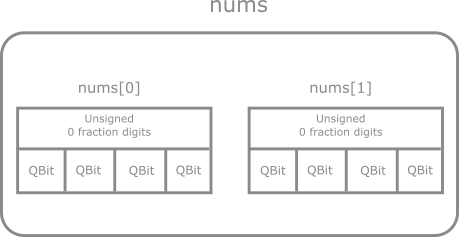

</center>

## 6. `QStruct`: struct-like quantum types

A `QStruct` groups named quantum fields into a single type, similar to a classical struct.

Example:

In [2]:
class MyState(QStruct):
    reg: QArray[QBit, 3]
    num: QNum[3, True, 1]
    flag: QBit

### Allocating and accessing struct fields

In [ ]:
@qfunc
def struct_demo(state: Output[MyState]):
    allocate(state)  # allocate all fields at once

    hadamard_transform(state.reg)  # operate on the qubit array field
    hadamard_transform(state.num)  # operate on the numeric field

    # Example: compare numeric field and write to bit field
    state.flag ^= state.num < 0

Key points:

- `allocate(state)` uses the type definition to allocate all fields.
- Access fields with `state.<field_name>`.
- A struct is a single composite quantum object; fields are not re-bound individually.

### Exercise 4: Portfolio-like struct

**Goal**: Create a simple struct for a financial-style example with:

- `reg`: 2-qubit register representing “asset ID”.
- `price`: 4-bit unsigned integer.
- `is_in_the_money`: one `QBit`.

**Tasks**

1. Define the struct type:

In [ ]:
class PortfolioState(QStruct):
    reg: QArray[QBit, 2]
    price: QNum[4, False, 0]  # 4-qbit unsigned integer
    is_in_the_money: QBit

2. Allocate and initialize in a `@qfunc`:

In [ ]:
@qfunc
def portfolio_demo(state: Output[PortfolioState]):
    allocate(state)

    # Put all asset IDs in superposition
    hadamard_transform(state.reg)

    # Example: simple payoff rule, e.g. flag set if price > 5
    state.is_in_the_money ^= state.price > 5

3. Synthesize and sample.
4. Observe how the `is_in_the_money` flag correlates with the encoded `price`.

<center>

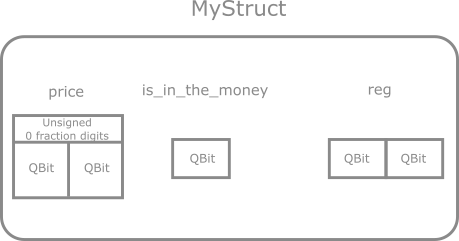

</center>

## 8. Learning checklist

After completing this tutorial, you should be comfortable with:

- Distinguishing between quantum objects, types, and variables.
- Declaring and using:
  - `QBit` and `QArray[QBit]` with indexing and slicing.
  - `QNum` with explicit numeric attributes and numeric assignments.
  - `QArray[QNum]` and reasoning about element count vs qubit count.
  - `QStruct` for grouping heterogeneous quantum fields.
- Reading synthesized circuits and relating them to Qmod type declarations.

## Learn more

- If you want to see another examples of usage, take a look at the [Modeling Guide](https://docs.classiq.io/latest/user-guide/)
- For a technical, complete explanation of quantum types and variables, see the language reference pages [Quantum Types](https://docs.classiq.io/latest/qmod-reference/language-reference/quantum-types/) and [Quantum Variables](https://docs.classiq.io/latest/qmod-reference/language-reference/quantum-variables/).
